# IDB_drilling_signal

## Import packages

In [1]:
!nvidia-smi

import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import scipy.io as scio
import time

from keras.models import load_model
from keras.utils.np_utils import to_categorical
from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tqdm import tqdm

HOST_path = "/hpctmp/e1097232"

random.seed(42)

def nameof(var):
    for name, value in globals().items():
        if value is var:
            return name

Wed Jun 21 18:32:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1D:00.0 Off |                    0 |
| N/A   33C    P0    42W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load signal data

In [2]:
RATE = 8192

def read_matFile(signal_path):
    signal_file = scio.loadmat(signal_path)
    signal_value = signal_file['samples']
    signal_value = np.squeeze(signal_value)
    print("signal_shape:", signal_value.shape, "sampling_rate:", RATE, "time:", len(signal_value)/RATE, "s")
    max_value = np.max(np.abs(signal_value))
    signal_value_normalized = signal_value / max_value
    return signal_value_normalized

def read_allFile(signal_path):
    signal_value, signal_rate = librosa.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
    print("signal_shape:", signal_value.shape, "sampling_rate:", signal_rate, "time:", len(signal_value)/signal_rate, "s")
    if signal_rate != RATE:
        signal_value = librosa.resample(signal_value, orig_sr=signal_rate, target_sr=RATE)
    max_value = np.max(np.abs(signal_value))
    signal_value_normalized = signal_value / max_value
    return signal_value_normalized

# granite
G32h = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/3-2h.mat"))
G41h = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/4-1h.mat"))
G42h = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/4-2h.mat"))
G43b = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/4-3b.mat"))
# sandstone
S11 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-1.mat"))
S12 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-2.mat"))
S13 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-3.mat"))
S14 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-4.mat"))
S21 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/2-1.mat"))
S22 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/2-2.mat"))
S23 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/2-3.mat"))
S31 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/3-1.mat"))
S32 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/3-2.mat"))
S33 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/3-3.mat"))
S41 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/4-1.mat"))
S42 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/4-2.mat"))
S43 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/4-3.mat"))
S51 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-1.mat"))
S52 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-2.mat"))
S53 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-3.mat"))
S54 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-4.mat"))
S61 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/6-1.mat"))
S62 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/6-2.mat"))
S63 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/6-3.mat"))
S71 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-1.mat"))
S72 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-2.mat"))
S73 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-3.mat"))
S74 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-4.mat"))
S81 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/8-1.mat"))
S82 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/8-2.mat"))
S83 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/8-3.mat"))
S91 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-1.mat"))
S92 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-2.mat"))
S93 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-3.mat"))
S94 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-4.mat"))
# basalt
B11 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/1-1.wav"))
B12 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/1-2.wav"))
B13 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/1-3.wav"))
B21 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/2-1.wav"))
B22 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/2-2.wav"))
B23 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/2-3.wav"))
B31 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/3-1.wav"))
B32 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/3-2.wav"))
B33 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/3-3.wav"))
B41 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/4-1.wav"))
B42 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/4-2.wav"))
B43 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/4-3.wav"))
B51 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-1.wav"))
B52 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-2.wav"))
B53 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-3.wav"))
B54 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-4.wav"))
B61 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/6-1.wav"))
B62 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/6-2.wav"))
B63 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/6-3.wav"))
B71 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/7-1.wav"))
B72 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/7-2.wav"))
B73 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/7-3.wav"))
B81 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/8-1.wav"))
B82 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/8-2.wav"))
B83 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/8-3.wav"))
B91 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/9-1.wav"))
B92 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/9-2.wav"))
B93 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/9-3.wav"))
print("------------------------------------")
print("All signal normalized with sr = 8192")

signal_shape: (8880128,) sampling_rate: 8192 time: 1084.0 s
signal_shape: (7216896,) sampling_rate: 8192 time: 880.96875 s
signal_shape: (11019776,) sampling_rate: 8192 time: 1345.1875 s
signal_shape: (22244352,) sampling_rate: 8192 time: 2715.375 s
signal_shape: (1248512,) sampling_rate: 8192 time: 152.40625 s
signal_shape: (3898112,) sampling_rate: 8192 time: 475.84375 s
signal_shape: (3248384,) sampling_rate: 8192 time: 396.53125 s
signal_shape: (1114368,) sampling_rate: 8192 time: 136.03125 s
signal_shape: (846336,) sampling_rate: 8192 time: 103.3125 s
signal_shape: (1461248,) sampling_rate: 8192 time: 178.375 s
signal_shape: (1584384,) sampling_rate: 8192 time: 193.40625 s
signal_shape: (727296,) sampling_rate: 8192 time: 88.78125 s
signal_shape: (1953536,) sampling_rate: 8192 time: 238.46875 s
signal_shape: (1200384,) sampling_rate: 8192 time: 146.53125 s
signal_shape: (354560,) sampling_rate: 8192 time: 43.28125 s
signal_shape: (1647872,) sampling_rate: 8192 time: 201.15625 s
si

## Plot signal data

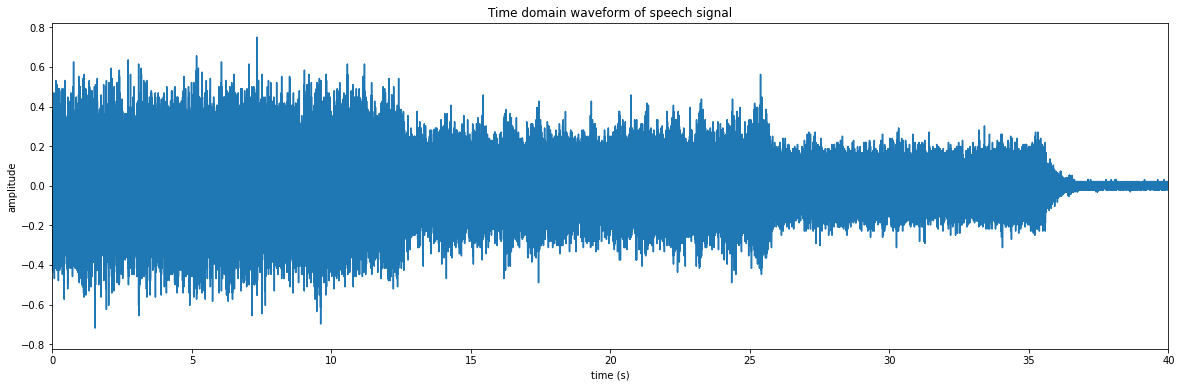

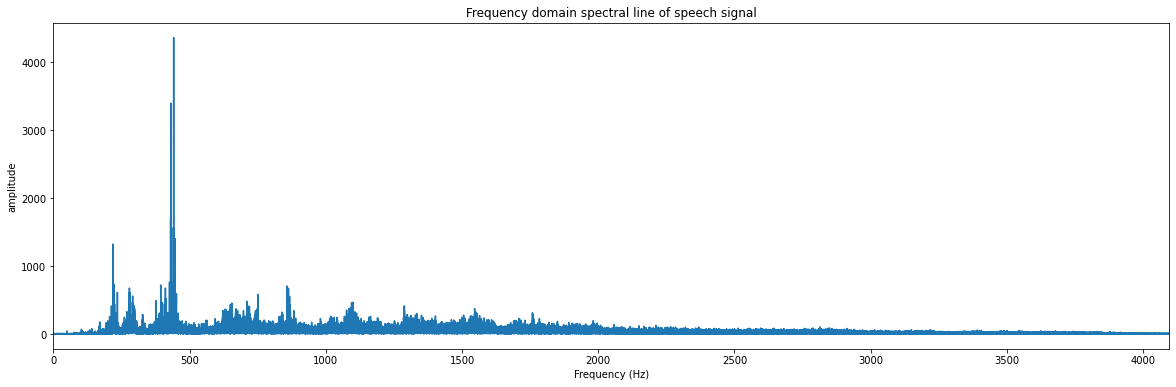

In [3]:
def displayWaveform(signal, rate):
  plt.figure(figsize=(20,6))
  max = np.max(np.absolute(signal))*1.2
  time = np.arange(0, len(SIGNAL)) / RATE
  plt.plot(time, signal)
  plt.title("Time domain waveform of speech signal")
  plt.xlabel("time (s)")
  plt.ylabel("amplitude")
  plt.xlim(0,len(SIGNAL)/RATE)
  ymin, ymax = plt.ylim()
  ylim = np.maximum(np.abs(ymin), np.abs(ymax))
  plt.ylim(-ylim, ylim)

def displaySpectrum(signal, rate):
  plt.figure(figsize=(20,6)) 
  s = np.fft.fft(signal)
  m = np.abs(s)
  n = len(signal)
  f = np.fft.fftfreq(n, 1/rate)
  plt.plot(f[:n//2],m[:n//2])
  plt.title("Frequency domain spectral line of speech signal")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("amplitude")
  plt.xlim(0, rate//2)

def displaySpectrogram(signal, rate, fftlen):    
  plt.figure(figsize=(8,6))
  plt.specgram(signal, NFFT=fftlen, Fs=rate, noverlap=int(fftlen*0.25), window=np.hanning(fftlen))
  plt.title('Linear-frequency power spectrogram')
  plt.xlabel('time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar(format="%+2.0f dB")
    
def displayMelspectrogram(signal, rate):
  plt.figure(figsize=(8,6))
  # melspectrogram = librosa.feature.melspectrogram(y=signal, sr=rate)
  D = np.abs(librosa.stft(signal))**2
  S = librosa.feature.melspectrogram(S=D, sr=rate)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, sr=rate, fmax=rate/2, x_axis='time', y_axis='mel') 
  plt.title('Mel-frequency spectrogram')
  plt.colorbar(format='%+2.0f dB')

def diaplayMFCC(signal, rate):
  plt.figure(figsize=(8,6))
  mfccs = librosa.feature.mfcc(y=signal, sr=rate)
  librosa.display.specshow(mfccs, sr=rate, x_axis='time')

def displayZCR(signal, rate):
  plt.figure(figsize=(8,3))
  zcrs = librosa.feature.zero_crossing_rate(signal)  
  plt.plot(zcrs[0])

def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

def displayCentroids(signal, rate):
  cent = librosa.feature.spectral_centroid(y=signal, sr=rate) 
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_centroid(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_centroid(S=np.abs(D), freq=freqs)
  times = librosa.times_like(cent)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, cent[0], label='Spectral centroid')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()
  librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[1])
  ax[1].plot(times, cent.T, label='Spectral centroid', color='w')
  ax[1].set(title='log Power spectrogram')
  ax[1].legend(loc='lower right')

def displayBandwidth(signal, rate):
  spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_bandwidth(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_bandwidth(S=np.abs(D), freq=freqs)
  times = librosa.times_like(spec_bw)
  centroid = librosa.feature.spectral_centroid(S=S)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()
  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax[1])
  ax[1].set(title='log Power spectrogram')
  ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]), np.minimum(centroid[0] + spec_bw[0], rate/2), alpha=0.5, label='Centroid +- bandwidth')
  ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
  ax[1].legend(loc='lower right')

def displayRolloff(signal, rate):
  librosa.feature.spectral_rolloff(y=signal, sr=rate)
  rolloff = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.99)
  rolloff_min = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.01)
  S, phase = librosa.magphase(librosa.stft(signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_rolloff(S=S, sr=rate)
  librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.95)
  fig, ax = plt.subplots()
  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax)
  ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
  ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
  ax.legend(loc='lower right')
  ax.set(title='log Power spectrogram')

def displayChromastft(signal, rate, fftlen):
  S = np.abs(librosa.stft(signal))
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)
  S = np.abs(librosa.stft(signal, n_fft=fftlen))**2
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])
  fig.colorbar(img, ax=[ax[0]])
  ax[0].label_outer()
  img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax[1])
  fig.colorbar(img, ax=[ax[1]])

def displayChromacqt(signal, rate, n_chroma, n_fft):
  chroma_stft = librosa.feature.chroma_stft(y=signal, sr=rate, n_chroma=n_chroma, n_fft=n_fft)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)
  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_stft')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cqt')
  fig.colorbar(img2, ax=ax)

def displayChromacens(signal, rate):
  chroma_cens = librosa.feature.chroma_cens(y=signal, sr=rate)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)
  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_cq')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_cens, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cens')
  fig.colorbar(img1, ax=ax)

def displayChromavqt(signal, rate, n_bins):
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate, n_chroma=n_bins)
  chroma_vq = librosa.feature.chroma_vqt(y=signal, sr=rate, intervals='ji5', bins_per_octave=n_bins)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0], bins_per_octave=n_bins)
  ax[0].set(ylabel='chroma_cqt')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_vq, y_axis='chroma_fjs', x_axis='time', ax=ax[1], bins_per_octave=n_bins, intervals='ji5')
  ax[1].set(ylabel='chroma_vqt')
  fig.colorbar(img2, ax=ax)

def plot_wave(signal, rate):  
  displayWaveform(signal, rate)
  displaySpectrum(signal, rate)
#   displaySpectrogram(signal, rate, fftlen=512)
#   displayMelspectrogram(signal, rate)
#   diaplayMFCC(signal, rate)
#   displayZCR(signal, rate)
#   displayCentroids(signal, rate)
#   displayBandwidth(signal, rate)
#   displayRolloff(signal, rate)
#   displayChromastft(signal, rate, fftlen=512)
#   displayChromacqt(signal, rate, n_chroma=12, n_fft=512)
#   displayChromacens(signal, rate)
#   displayChromavqt(signal, rate, n_bins=24)

SIGNAL = G32h[-40*RATE:]
plot_wave(SIGNAL, RATE)
IPython.display.Audio(data=SIGNAL, rate=RATE)

## Cut signal data

In [4]:
G32h = G32h[0:1056*RATE]
G41h = G41h[120*RATE:840*RATE]
G42h = G42h[0:1260*RATE]
G43b = G43b[100*RATE:2240*RATE]

S11 = S11[0:150*RATE]
S12 = S12[210*RATE:416*RATE]
S13 = S13[140*RATE:374*RATE]
S14 = S14[2*RATE:136*RATE]
S21 = S21[0:103*RATE]
S22 = S22[0:156*RATE]
S23 = S23[42*RATE:126*RATE]
S31 = S31[0:86*RATE]
S32 = S32[76*RATE:213*RATE]
S33 = S33[33*RATE:130*RATE]
S41 = S41[0:41*RATE]
S42 = S42[100*RATE:123*RATE]
S43 = S43[115*RATE:135*RATE]
S51 = S51[3*RATE:28*RATE]
S52 = S52[103*RATE:126*RATE]
S53 = S53[126*RATE:153*RATE]
S54 = S54[157*RATE:181*RATE]
S61 = S61[40*RATE:57*RATE]
S62 = S62[128*RATE:150*RATE]
S63 = S63[35*RATE:51*RATE]
S71 = S71[16*RATE:88*RATE]
S72 = S72[86*RATE:328*RATE]
S73 = S73[116*RATE:260*RATE]
S74 = S74[112*RATE:286*RATE]
S81 = S81[0:78*RATE]
S82 = S82[84*RATE:189*RATE]
S83 = S83[130*RATE:312*RATE]
S91 = S91[0:45*RATE]
S92 = S92[50*RATE:108*RATE]
S93 = S93[72*RATE:228*RATE]
S94 = S94[68*RATE:258*RATE]

B11 = B11[4*RATE:484*RATE]
B12 = B12[4*RATE:382*RATE]
B13 = B13[0*RATE:280*RATE]
B21 = B21[4*RATE:157*RATE]
B22 = B22[4*RATE:170*RATE]
B23 = B23[8*RATE:166*RATE]
B31 = B31[15*RATE:146*RATE]
B32 = B32[12*RATE:258*RATE]
B33 = B33[12*RATE:177*RATE]
B41 = B41[10*RATE:109*RATE]
B42 = B42[6*RATE:64*RATE]
B43 = B43[6*RATE:88*RATE]
B51 = B51[8*RATE:78*RATE]
B52 = B52[4*RATE:268*RATE]
B53 = B53[8*RATE:97*RATE]
B54 = B54[4*RATE:123*RATE]
B61 = B61[4*RATE:205*RATE]
B62 = B62[4*RATE:135*RATE]
B63 = B63[6*RATE:124*RATE]
B71 = B71[4*RATE:296*RATE]
B72 = B72[4*RATE:204*RATE]
B73 = B73[10*RATE:303*RATE]
B81 = B81[6*RATE:182*RATE]
B82 = B82[6*RATE:183*RATE]
B83 = B83[10*RATE:219*RATE]
B91 = B91[4*RATE:201*RATE]
B92 = B92[6*RATE:138*RATE]
B93 = B93[0*RATE:158*RATE]
 
signals_list = ["G32h", "G41h", "G42h", "G43b",
              "S11", "S12", "S13", "S14", "S21", "S22", "S23", "S31", "S32", "S33",
              "S41", "S42", "S43", "S51", "S52", "S53", "S54", "S61", "S62", "S63",
              "S71", "S72", "S73", "S74", "S81", "S82", "S83", "S91", "S92", "S93", "S94",
              "B11", "B12", "B13", "B21", "B22", "B23", "B31", "B32", "B33",
              "B41", "B42", "B43", "B51", "B52", "B53", "B54", "B61", "B62", "B63", 
              "B71", "B72", "B73", "B81", "B82", "B83", "B91", "B92", "B93"]

def check_all():
    for signals in signals_list:
        print(signals, eval(signals).shape)
check_all()

G32h (8650752,)
G41h (5898240,)
G42h (10321920,)
G43b (17530880,)
S11 (1228800,)
S12 (1687552,)
S13 (1916928,)
S14 (1097728,)
S21 (843776,)
S22 (1277952,)
S23 (688128,)
S31 (704512,)
S32 (1122304,)
S33 (794624,)
S41 (335872,)
S42 (188416,)
S43 (163840,)
S51 (204800,)
S52 (188416,)
S53 (221184,)
S54 (196608,)
S61 (139264,)
S62 (180224,)
S63 (131072,)
S71 (589824,)
S72 (1982464,)
S73 (1179648,)
S74 (1425408,)
S81 (638976,)
S82 (860160,)
S83 (1490944,)
S91 (368640,)
S92 (475136,)
S93 (1277952,)
S94 (1556480,)
B11 (3932160,)
B12 (3096576,)
B13 (2293760,)
B21 (1253376,)
B22 (1359872,)
B23 (1294336,)
B31 (1073152,)
B32 (2015232,)
B33 (1351680,)
B41 (811008,)
B42 (475136,)
B43 (671744,)
B51 (573440,)
B52 (2162688,)
B53 (729088,)
B54 (974848,)
B61 (1646592,)
B62 (1073152,)
B63 (966656,)
B71 (2392064,)
B72 (1638400,)
B73 (2400256,)
B81 (1441792,)
B82 (1449984,)
B83 (1712128,)
B91 (1613824,)
B92 (1081344,)
B93 (1294336,)


## Pick signal data

In [5]:
def pick_signal(signals):
  sample_size = int(RATE/2)        # int(RATE/2)
  sample_step = int(sample_size/2) # int(RATE/4)
  sample_data = []
  for i in tqdm(range((len(signals)-sample_size) // sample_step)):
    sample_data.append(signals[i*sample_step : (i*sample_step+sample_size)])
  sample_data = np.stack(sample_data)
  sample_data = np.squeeze(sample_data)
  return sample_data

G32h = pick_signal(G32h)
G41h = pick_signal(G41h)
G42h = pick_signal(G42h)
G43b = pick_signal(G43b)

S11 = pick_signal(S11)
S12 = pick_signal(S12)
S13 = pick_signal(S13)
S14 = pick_signal(S14)
S21 = pick_signal(S21)
S22 = pick_signal(S22)
S23 = pick_signal(S23)
S31 = pick_signal(S31)
S32 = pick_signal(S32)
S33 = pick_signal(S33)
S41 = pick_signal(S41)
S42 = pick_signal(S42)
S43 = pick_signal(S43)
S51 = pick_signal(S51)
S52 = pick_signal(S52)
S53 = pick_signal(S53)
S54 = pick_signal(S54)
S61 = pick_signal(S61)
S62 = pick_signal(S62)
S63 = pick_signal(S63)
S71 = pick_signal(S71)
S72 = pick_signal(S72)
S73 = pick_signal(S73)
S74 = pick_signal(S74)
S81 = pick_signal(S81)
S82 = pick_signal(S82)
S83 = pick_signal(S83)
S91 = pick_signal(S91)
S92 = pick_signal(S92)
S93 = pick_signal(S93)
S94 = pick_signal(S94)

B11 = pick_signal(B11)
B12 = pick_signal(B12)
B13 = pick_signal(B13)
B21 = pick_signal(B21)
B22 = pick_signal(B22)
B23 = pick_signal(B23)
B31 = pick_signal(B31)
B32 = pick_signal(B32)
B33 = pick_signal(B33)
B41 = pick_signal(B41)
B42 = pick_signal(B42)
B43 = pick_signal(B43)
B51 = pick_signal(B51)
B52 = pick_signal(B52)
B53 = pick_signal(B53)
B54 = pick_signal(B54)
B61 = pick_signal(B61)
B62 = pick_signal(B62)
B63 = pick_signal(B63)
B71 = pick_signal(B71)
B72 = pick_signal(B72)
B73 = pick_signal(B73)
B81 = pick_signal(B81)
B82 = pick_signal(B82)
B83 = pick_signal(B83)
B91 = pick_signal(B91)
B92 = pick_signal(B92)
B93 = pick_signal(B93)

check_all()

100%|███████████████████████████████████████████████████████████████████| 630/630 [00:00<00:00, 1843971.75it/s]


G32h (4222, 4096)
G41h (2878, 4096)
G42h (5038, 4096)
G43b (8558, 4096)
S11 (598, 4096)
S12 (822, 4096)
S13 (934, 4096)
S14 (534, 4096)
S21 (410, 4096)
S22 (622, 4096)
S23 (334, 4096)
S31 (342, 4096)
S32 (546, 4096)
S33 (386, 4096)
S41 (162, 4096)
S42 (90, 4096)
S43 (78, 4096)
S51 (98, 4096)
S52 (90, 4096)
S53 (106, 4096)
S54 (94, 4096)
S61 (66, 4096)
S62 (86, 4096)
S63 (62, 4096)
S71 (286, 4096)
S72 (966, 4096)
S73 (574, 4096)
S74 (694, 4096)
S81 (310, 4096)
S82 (418, 4096)
S83 (726, 4096)
S91 (178, 4096)
S92 (230, 4096)
S93 (622, 4096)
S94 (758, 4096)
B11 (1918, 4096)
B12 (1510, 4096)
B13 (1118, 4096)
B21 (610, 4096)
B22 (662, 4096)
B23 (630, 4096)
B31 (522, 4096)
B32 (982, 4096)
B33 (658, 4096)
B41 (394, 4096)
B42 (230, 4096)
B43 (326, 4096)
B51 (278, 4096)
B52 (1054, 4096)
B53 (354, 4096)
B54 (474, 4096)
B61 (802, 4096)
B62 (522, 4096)
B63 (470, 4096)
B71 (1166, 4096)
B72 (798, 4096)
B73 (1170, 4096)
B81 (702, 4096)
B82 (706, 4096)
B83 (834, 4096)
B91 (786, 4096)
B92 (526, 4096)
B9

## Convert signal data

signal shape:  (4096,)
waveform:  (4096,)
spectrum:  (2048,)
spectrogram_db:  (1025, 9)
mfccs:  (20, 9)


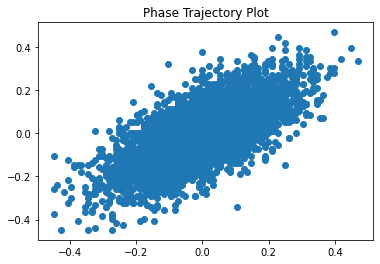

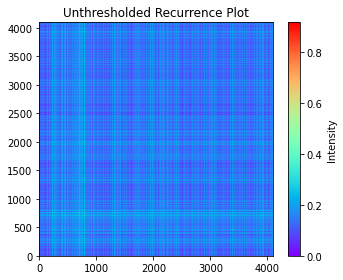

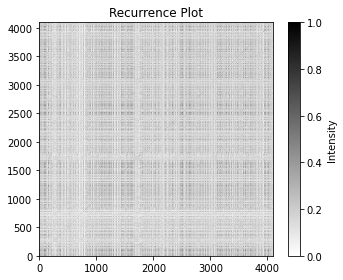

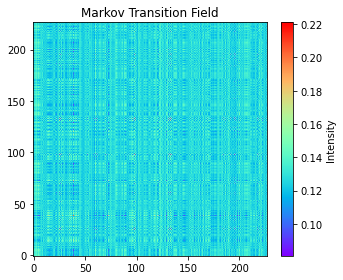

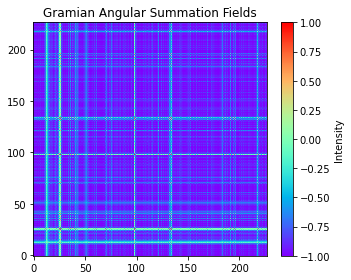

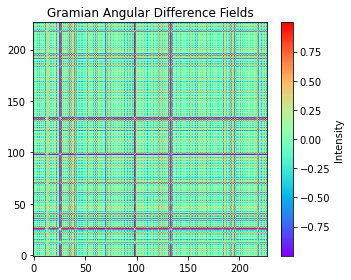

signal shape:  (227,)
waveform:  (227,)
spectrum:  (113,)
spectrogram_db:  (1025, 1)
mfccs:  (20, 1)


/home/svu/e1097232/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=227
  warnings.warn(


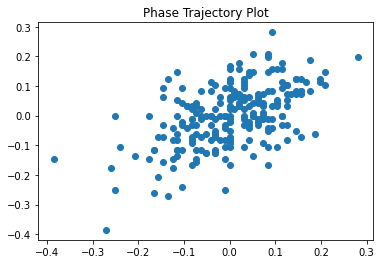

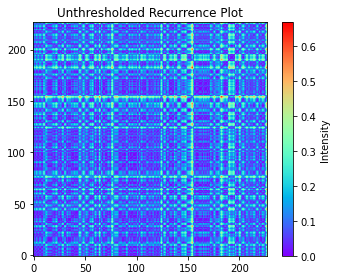

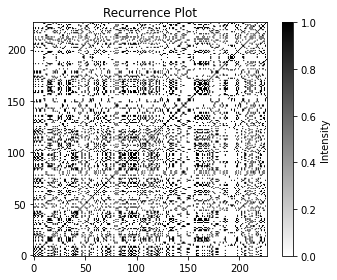

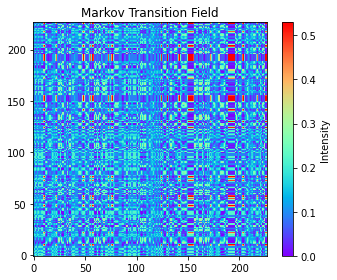

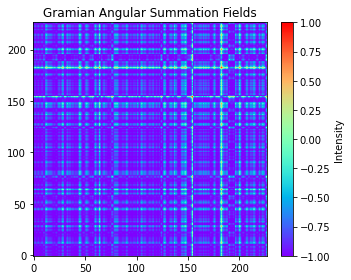

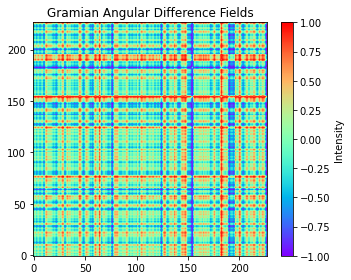

array([[ 0.        , -0.15625   ,  0.        , ...,  0.16023708,
        -0.3982178 , -0.84413782],
       [ 0.15625   ,  0.        ,  0.15625   , ...,  0.3125    ,
        -0.25      , -0.75      ],
       [ 0.        , -0.15625   ,  0.        , ...,  0.16023708,
        -0.3982178 , -0.84413782],
       ...,
       [-0.16023708, -0.3125    , -0.16023708, ...,  0.        ,
        -0.54005626, -0.91913764],
       [ 0.3982178 ,  0.25      ,  0.3982178 , ...,  0.54005626,
         0.        , -0.56082492],
       [ 0.84413782,  0.75      ,  0.84413782, ...,  0.91913764,
         0.56082492,  0.        ]])

In [6]:
# 1D original
def wave2wave(X, show):
    if show==1:
        print("waveform: ", X.shape)
    return X

# 1D spectrum
def wave2spectrum(X, show):
    spectrum = np.abs(np.fft.fft(X))
    spectrum = spectrum[0:len(spectrum)//2]
    if show==1:
        print("spectrum: ", spectrum.shape)
    return spectrum

# 2D spectrogram
def wave2spectrogram(X, show):
    spectrogram = np.abs(librosa.stft(X))
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    if show==1:
        print("spectrogram_db: ", spectrogram_db.shape)
    return spectrogram_db

# 2D mfcc
def wave2mfcc(X, show):
    mfccs = librosa.feature.mfcc(y=X, sr=RATE)
    if show==1:
         print("mfccs: ", mfccs.shape)
    return mfccs

# 2D ptp
def wave2ptp(X, show):
    autocorr = np.correlate(X, X, mode='full')
    time_delay = np.argmax(autocorr[len(autocorr)//2:]) + 1
    embedding = np.array([X[:-2*time_delay], X[time_delay:-time_delay]]).T
    if show==1:
        plt.scatter(embedding[:, 0], embedding[:, 1])
        plt.title('Phase Trajectory Plot')
        plt.show()
    return embedding

# 2D urp
def wave2urp(X, show):
    urp = RecurrencePlot(threshold=None)
    X_urp = urp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_urp, cmap='rainbow', origin='lower')
        plt.title('Unthresholded Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_urp

# 2D rp
def wave2rp(X, show):
    rp = RecurrencePlot(threshold='point', percentage=20)
    X_rp = rp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_rp, cmap='binary', origin='lower')
        plt.title('Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_rp

#2D mtf
def wave2mtf(X, show):
    mtf = MarkovTransitionField(image_size=227)
    X_mtf = mtf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_mtf, cmap='rainbow', origin='lower')
        plt.title('Markov Transition Field')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_mtf

# 2D ga(s)f
def wave2gasf(X, show):
    gasf = GramianAngularField(image_size=227, method='summation')
    X_gasf = gasf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gasf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Summation Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gasf

# 2D ga(d)f
def wave2gadf(X, show):
    gadf = GramianAngularField(image_size=227, method='difference')
    X_gadf = gadf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gadf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Difference Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gadf

SIGNAL = G32h[0]
print("signal shape: ", SIGNAL.shape)
wave2wave(SIGNAL, 1)
wave2spectrum(SIGNAL, 1)
wave2spectrogram(SIGNAL, 1)
wave2mfcc(SIGNAL, 1)
wave2ptp(SIGNAL, 1)
wave2urp(SIGNAL, 1)
wave2rp(SIGNAL, 1)
wave2mtf(SIGNAL, 1)
wave2gasf(SIGNAL, 1)
wave2gadf(SIGNAL, 1)
SIGNAL = SIGNAL[0:227]
print("signal shape: ", SIGNAL.shape)
wave2wave(SIGNAL, 1)
wave2spectrum(SIGNAL, 1)
wave2spectrogram(SIGNAL, 1)
wave2mfcc(SIGNAL, 1)
wave2ptp(SIGNAL, 1)
wave2urp(SIGNAL, 1)
wave2rp(SIGNAL, 1)
wave2mtf(SIGNAL, 1)
wave2gasf(SIGNAL, 1)
wave2gadf(SIGNAL, 1)

In [7]:
def wave2others(signals):
    function = wave2gasf
    results = []
    if function == wave2rp or function == wave2urp:
        random.seed(42)
        shorter_length = 227
        for signal in tqdm(signals):
            shorter_arrays = [signal[i:i+shorter_length] for i in range(len(signal) - shorter_length + 1)]
            signal = random.choice(shorter_arrays)
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    else:
        for signal in tqdm(signals):
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    results = np.array(results)
    return results

G32h = wave2others(G32h)
G41h = wave2others(G41h)
G42h = wave2others(G42h)
G43b = wave2others(G43b)

S11 = wave2others(S11)
S12 = wave2others(S12)
S13 = wave2others(S13)
S14 = wave2others(S14)
S21 = wave2others(S21)
S22 = wave2others(S22)
S23 = wave2others(S23)
S31 = wave2others(S31)
S32 = wave2others(S32)
S33 = wave2others(S33)
S41 = wave2others(S41)
S42 = wave2others(S42)
S43 = wave2others(S43)
S51 = wave2others(S51)
S52 = wave2others(S52)
S53 = wave2others(S53)
S54 = wave2others(S54)
S61 = wave2others(S61)
S62 = wave2others(S62)
S63 = wave2others(S63)
S71 = wave2others(S71)
S72 = wave2others(S72)
S73 = wave2others(S73)
S74 = wave2others(S74)
S81 = wave2others(S81)
S82 = wave2others(S82)
S83 = wave2others(S83)
S91 = wave2others(S91)
S92 = wave2others(S92)
S93 = wave2others(S93)
S94 = wave2others(S94)

B11 = wave2others(B11)
B12 = wave2others(B12)
B13 = wave2others(B13)
B21 = wave2others(B21)
B22 = wave2others(B22)
B23 = wave2others(B23)
B31 = wave2others(B31)
B32 = wave2others(B32)
B33 = wave2others(B33)
B41 = wave2others(B41)
B42 = wave2others(B42)
B43 = wave2others(B43)
B51 = wave2others(B51)
B52 = wave2others(B52)
B53 = wave2others(B53)
B54 = wave2others(B54)
B61 = wave2others(B61)
B62 = wave2others(B62)
B63 = wave2others(B63)
B71 = wave2others(B71)
B72 = wave2others(B72)
B73 = wave2others(B73)
B81 = wave2others(B81)
B82 = wave2others(B82)
B83 = wave2others(B83)
B91 = wave2others(B91)
B92 = wave2others(B92)
B93 = wave2others(B93)

check_all()

100%|██████████████████████████████████████████████████████████████████████| 630/630 [00:00<00:00, 1287.07it/s]


G32h (4222, 227, 227)
G41h (2878, 227, 227)
G42h (5038, 227, 227)
G43b (8558, 227, 227)
S11 (598, 227, 227)
S12 (822, 227, 227)
S13 (934, 227, 227)
S14 (534, 227, 227)
S21 (410, 227, 227)
S22 (622, 227, 227)
S23 (334, 227, 227)
S31 (342, 227, 227)
S32 (546, 227, 227)
S33 (386, 227, 227)
S41 (162, 227, 227)
S42 (90, 227, 227)
S43 (78, 227, 227)
S51 (98, 227, 227)
S52 (90, 227, 227)
S53 (106, 227, 227)
S54 (94, 227, 227)
S61 (66, 227, 227)
S62 (86, 227, 227)
S63 (62, 227, 227)
S71 (286, 227, 227)
S72 (966, 227, 227)
S73 (574, 227, 227)
S74 (694, 227, 227)
S81 (310, 227, 227)
S82 (418, 227, 227)
S83 (726, 227, 227)
S91 (178, 227, 227)
S92 (230, 227, 227)
S93 (622, 227, 227)
S94 (758, 227, 227)
B11 (1918, 227, 227)
B12 (1510, 227, 227)
B13 (1118, 227, 227)
B21 (610, 227, 227)
B22 (662, 227, 227)
B23 (630, 227, 227)
B31 (522, 227, 227)
B32 (982, 227, 227)
B33 (658, 227, 227)
B41 (394, 227, 227)
B42 (230, 227, 227)
B43 (326, 227, 227)
B51 (278, 227, 227)
B52 (1054, 227, 227)
B53 (354, 227, 2

## Classification

### Build dataset

In [ ]:
# Rock type(3-classes: 0_granite, 1_sandstone, 2_bas
X_0 = np.concatenate((G32h, G41h, G42h, G43b), axis=0)
X_1 = np.concatenate((S11, S12, S13, S14, S21, S22, S23, S31, S32, S33,
                      S41, S42, S43, S51, S52, S53, S54, S61, S62, S63,
                      S71, S72, S73, S74, S81, S82, S83, S91, S92, S93, S94), axis=0)
X_2 = np.concatenate((B11, B12, B13, B21, B22, B23, B31, B32, B33,
                      B41, B42, B43, B51, B52, B53, B54, B61, B62, B63,
                      B71, B72, B73, B81, B82, B83, B91, B92, B93), axis=0)
min_size = min(len(X_0), len(X_1), len(X_2))
X_0 = X_0[np.random.choice(len(X_0), size=min_size, replace=False)]
X_1 = X_1[np.random.choice(len(X_1), size=min_size, replace=False)]
X_2 = X_2[np.random.choice(len(X_2), size=min_size, replace=False)]
Y_0 = np.repeat(0, len(X_0))
Y_1 = np.repeat(1, len(X_1))
Y_2 = np.repeat(2, len(X_2))
X_set = np.concatenate((X_0, X_1, X_2), axis=0)
Y_set = np.concatenate((Y_0, Y_1, Y_2), axis=0)
num_classes = len(np.unique(Y_set))

# # Bit type(3-classes: 0_IDB, 1_PDC, 2_MMC)
# X_0 = np.concatenate((G32h, G41h, G42h, G43b,
#                       S11, S12, S13, S14, S21, S22, S23, S31, S32, S33,
#                       B11, B12, B13, B21, B22, B23, B31, B32, B33), axis=0)
# X_1 = np.concatenate((S41, S42, S43, S51, S52, S53, S54, S61, S62, S63,
#                       B41, B42, B43, B51, B52, B53, B54, B61, B62, B63), axis=0)
# X_2 = np.concatenate((S71, S72, S73, S74, S81, S82, S83, S91, S92, S93, S94,
#                       B71, B72, B73, B81, B82, B83, B91, B92, B93), axis=0)
# min_size = min(len(X_0), len(X_1), len(X_2))
# X_0 = X_0[np.random.choice(len(X_0), size=min_size, replace=False)]
# X_1 = X_1[np.random.choice(len(X_1), size=min_size, replace=False)]
# X_2 = X_2[np.random.choice(len(X_2), size=min_size, replace=False)]
# Y_0 = np.repeat(0, len(X_0))
# Y_1 = np.repeat(1, len(X_1))
# Y_2 = np.repeat(2, len(X_2))
# X_set = np.concatenate((X_0, X_1, X_2), axis=0)
# Y_set = np.concatenate((Y_0, Y_1, Y_2), axis=0)
# num_classes = len(np.unique(Y_set)) 

print(type(X_0), X_0.shape, type(Y_0), type(Y_0[0]), Y_0.shape)
print(type(X_1), X_1.shape, type(Y_1), type(Y_1[0]), Y_1.shape)
print(type(X_2), X_2.shape, type(Y_2), type(Y_2[0]), Y_2.shape)
print(type(X_set), X_set.shape, type(Y_set), type(Y_set[0]), Y_set.shape)

### ML model

#### Normal model

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

# print("x_train:", x_train.shape)
# print("y_train:", y_train.shape)  
# print("x_test:", x_test.shape)
# print("y_test:", y_test.shape)

In [ ]:
# import xgboost as xgb
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier

# # K-Nearest Neighbors (KNN)
# def make_knn():
#     model = KNeighborsClassifier(n_neighbors=num_classes) 
#     model.fit(x_train, y_train)
#     return model

# # Decision Tree Classifier
# def make_dtc():
#     model = DecisionTreeClassifier()
#     model.fit(x_train, y_train)
#     return model

# # Random Forest Classifier
# def make_rfc():
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(x_train, y_train)
#     return model

# # Naive Bayes Classifier
# def make_nbc():
#     model = GaussianNB()
#     model.fit(x_train, y_train)
#     return model

# time0 = time.time()
# model = make_rfc()
# time1 = time.time()
# y_pred = model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')
# classification_report = classification_report(y_test, y_pred)
# confusion_matrix = confusion_matrix(y_test, y_pred)
# time2 = time.time()

# print("Train time:", time1-time0)
# print("Predict time:", time2-time1)
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)
# print("\nClassification Report:\n", classification_report)
# print("\nConfusion Matrix:\n", confusion_matrix)

### DL model

In [ ]:
X_set = np.expand_dims(X_set, axis=-1)
Y_set = to_categorical(Y_set, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)  
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling1D, GlobalAveragePooling2D, Input, MaxPooling1D, MaxPooling2D

def make_1Dgap():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling1D(2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_1Ddense():
    model = Sequential()
    model.add(Conv1D(64, 7, strides=2, activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling1D(3, strides=2, padding='same'))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(Concatenate())
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(Concatenate())
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(Concatenate())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_1Dalex():
    model = Sequential()
    model.add(Conv1D(96, 11, strides=4, activation='relu', input_shape=x_train.shape[1:]))  # (227, 1)
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Conv1D(384, 3, activation='relu'))
    model.add(Conv1D(384, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_1Dvgg():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    return model


def make_2Dgap():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_2Ddense():
    model = Sequential()
    model.add(Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Concatenate())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Concatenate())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Concatenate())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_2Dalex():
    model = Sequential()
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=x_train.shape[1:]))  # (227, 227, 3)
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  
    return model

def make_2Dvgg():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = make_2Dgap()
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

### Complete & Train

In [ ]:
time0 = time.time()
model.compile(optimizer='adam',                # tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
              loss='categorical_crossentropy', # loss='binary_crossentropy'
              metrics=['accuracy',
                       keras.metrics.AUC(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall()])

callbacks = [
            #  keras.callbacks.ModelCheckpoint("best_model.hdf5",
            #                                  monitor="loss",
            #                                  mode="min",
            #                                  save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_loss",
                                           mode="min",
                                           verbose=1,
                                           patience=10,
                                           restore_best_weights=True), 
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.2,
                                               patience=2,
                                               min_lr=0.000001),
            # keras.callbacks.TensorBoard(log_dir=os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_logs"),
            #                             histogram_freq=1,
            #                             write_graph=True, 
            #                             write_images=True),
            ]

history = model.fit(x_train, y_train,
                    validation_split=0.2, 
                    epochs=200, 
                    batch_size=64, 
                    callbacks=callbacks, 
                    shuffle=True)
time1 = time.time()

### Show model results

In [ ]:
y_test_true = np.argmax(y_test, axis=1)
time2 = time.time()
y_test_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test_true, y_test_pred)
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(x_test, y_test)
time3 = time.time()
print("Train time:", time1-time0)
print("Predict time:", time3-time2)
print("test_loss: ", test_loss)
print("test_accuracy: ", test_accuracy)
print("test_auc: ", test_auc)
print("test_precision: ", test_precision)
print("test_recall: ", test_recall)
print("confusion matrix: \n", cm)

### Save model results

In [ ]:
eval_dict = {"y_test_true":y_test_true, "y_test_pred":y_test_pred, "test_loss":test_loss, "test_accuracy":test_accuracy, "test_auc":test_auc, "test_precision":test_precision, "test_recall":test_recall}
model.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_model.hdf5"))
np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_history.npy"), history.history)
np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.npy"), eval_dict)

### Load model results

In [ ]:
# model = load_model(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_model.hdf5"))
# hist = np.load(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_history.npy"), allow_pickle=True).item()
# eval_dict = np.load(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.npy"), allow_pickle=True).item()

### Plot model results

In [ ]:
def plot_history_metrics(history):
  total_plots = len(history)
  cols = total_plots // 2
  rows = total_plots // cols
  if total_plots % cols != 0:
    rows += 1
  pos = range(1, total_plots + 1)
  plt.figure(figsize=(15, 10))
  for i, (key, value) in enumerate(history.items()):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value)), value)
    plt.title(str(key))
  plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.png"))
 
plot_history_metrics(history.history)

## Regression

### Data pre-treatment

In [ ]:
# X_set = np.concatenate((S11,S12,S13,S14,S21,S22,S23,S31,S32,S33,S41,S42,S43,S51,S52,S53,S54,S61,S62,S63,S71,S72,S73,S74,S81,S82,S83,S91,S92,S93,S94), axis=0)
# X_set = X_set.reshape((X_set.shape[0], X_set.shape[1], 1))
# S1Y = [0,0,0, 150, 200, 8]
# S2Y = [0,0,0, 250, 250, 10]
# S3Y = [0,0,0, 350, 150, 6]
# S4Y = [0,1,0, 150, 250, 6]
# S5Y = [0,1,0, 250, 150, 8]
# S6Y = [0,1,0, 350, 200, 10]
# S7Y = [0,0,1, 150, 150, 10]
# S8Y = [0,0,1, 250, 200, 6]
# S9Y = [0,0,1, 350, 250, 8]
# S1L = len(S11)+len(S12)+len(S13)+len(S14)
# S2L = len(S21)+len(S22)+len(S23)
# S3L = len(S31)+len(S32)+len(S33)
# S4L = len(S41)+len(S42)+len(S43)
# S5L = len(S51)+len(S52)+len(S53)+len(S54)
# S6L = len(S61)+len(S62)+len(S63)
# S7L = len(S71)+len(S72)+len(S73)+len(S74)
# S8L = len(S81)+len(S82)+len(S83)
# S9L = len(S91)+len(S92)+len(S93)+len(S94)
# S_1 = [S1Y for _ in range(S1L)]
# S_2 = [S2Y for _ in range(S2L)]
# S_3 = [S3Y for _ in range(S3L)]
# S_4 = [S4Y for _ in range(S4L)]
# S_5 = [S5Y for _ in range(S5L)]
# S_6 = [S6Y for _ in range(S6L)]
# S_7 = [S7Y for _ in range(S7L)]
# S_8 = [S8Y for _ in range(S8L)]
# S_9 = [S9Y for _ in range(S9L)]
# Y_set = np.concatenate((S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9), axis=0)
# num_targets = Y_set.shape[1]
# x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.25, random_state=42)

### Model establishment

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
# from keras.layers import Activation, Dropout, Flatten, Dense

# def make_cnn_model():
#     model = Sequential()
#     model.add(Conv1D(64, 3, input_shape=x_train.shape[1:], padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(64, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(128, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(128, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(4096))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(num_targets, activation='linear'))
#     return model

# model = make_cnn_model()
# model.summary()
# # keras.utils.plot_model(model, show_shapes=True)

### Complete & Train

In [ ]:
# model.compile(optimizer='adam', loss='mse')

# callbacks = [
#             #  keras.callbacks.ModelCheckpoint("best_model.hdf5",
#             #                                  monitor="loss",
#             #                                  mode="min",
#             #                                  save_best_only=True),
#              keras.callbacks.EarlyStopping(monitor="val_loss",
#                                            mode="min",
#                                            verbose=1,
#                                            patience=10,
#                                            restore_best_weights=True), 
#              keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
#                                                factor=0.2,
#                                                patience=2,
#                                                min_lr=0.000001),
#             # keras.callbacks.TensorBoard(log_dir=os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_logs"),
#             #                             histogram_freq=1,
#             #                             write_graph=True, 
#             #                             write_images=True),
#             ]

# history = model.fit(x_train, y_train,
#                     validation_split=0.2, 
#                     epochs=200, 
#                     batch_size=32, 
#                     # callbacks=callbacks, 
#                     shuffle=True)

### Show model results

In [ ]:
# y_test_true = y_test
# y_test_pred = model.predict(x_test)
# test_loss = model.evaluate(x_test, y_test)

### Save model results

In [ ]:
# eval_dict = {"y_test_true":y_test_true, "y_test_pred":y_test_pred, "test_loss":test_loss}

# model.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_model.hdf5"))
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_history.npy"), history.history)
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_evaluation.npy"), eval_dict)

### Load model results

In [ ]:
# from keras.models import load_model

# model = load_model("/home/svu/e1097232/IDB_drilling_signal/outputs/R_model.hdf5")
# hist = np.load("/home/svu/e1097232/IDB_drilling_signal/outputs/R_history.npy", allow_pickle=True)
# eval_dict = np.load("/home/svu/e1097232/IDB_drilling_signal/outputs/R_evaluation.npy", allow_pickle=True)

### Plot model results

In [ ]:
# # Plot Loss-Epoch
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train set', 'Test set'], loc='upper left')
# plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_loss.png"))
# plt.show()